# Example to connect to postgres

This is a tutorial to connect to our PostgreSQL database using python.

First you need to install the following libraries:
- psycopg2
- python-dotenv

Then you need to create a file with the name ".env". This file will contain the connection information and your credentials. This is an example:

```
DB_HOST=host_name
DB_NAME=postgres
DB_USER=my_user
DB_PASSWORD=my_password
DB_PORT=5432
```

After that you´re all set. We will import your credentials and connect to the database.

In [18]:
import os
import psycopg2 # PostgreSQL database adapter for Python
from dotenv import load_dotenv # Reads the key-value pair from .env file and adds them to environment variable

# Load environment variables from .env file
load_dotenv()

# Accessing credentials
db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_port = os.getenv("DB_PORT")

In [19]:
# Connect to the database
conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port
)

Now we can query our data (write sql code) and store it as a pandas dataframe

In [20]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [21]:
query="""
    select * 
    from agg.tidy_data_final  
    where year = 2020 and month between 1 and 3
"""

In [22]:
df = pd.read_sql_query(query, conn)

C:\Users\xlow6\AppData\Local\Temp\ipykernel_2228\1553155693.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [23]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175152 entries, 0 to 175151
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype              
---  ------                     --------------   -----              
 0   timestamp                  175152 non-null  datetime64[ns, UTC]
 1   site                       175152 non-null  int64              
 2   year                       175152 non-null  int64              
 3   month                      175152 non-null  int64              
 4   day                        175152 non-null  int64              
 5   hour                       175152 non-null  int64              
 6   minute                     175152 non-null  int64              
 7   day_of_week                175152 non-null  int64              
 8   season                     175152 non-null  int64              
 9   net_load                   175152 non-null  float64            
 10  precipitation              175152 non-null  float64     

In [24]:
# Average hourly
from sklearn.preprocessing import MinMaxScaler
df = df.drop('timestamp', axis=1)
#df = df.groupby(['year','month', 'day', 'hour','minute']).mean().reset_index()
#df['net_load_norm'] = df['net_load'] / max(abs(df['net_load']))
df['datetime'] = pd.to_datetime(df[['year','month', 'day', 'hour','minute']])
df = df.sort_values(by='datetime')


In [25]:
columns_to_keep = ['net_load', 'datetime','solar_radiation','sunshine_duration','precipitation_probability','site','weekend_or_bank_holiday']

# Keep only the specified columns
df = df.loc[:, columns_to_keep]
df['net_load'] = df['net_load'].astype('float32')
df['solar_radiation'] = df['solar_radiation'].astype('float32')
df['sunshine_duration'] = df['sunshine_duration'].astype('float32')
df['precipitation_probability'] = df['precipitation_probability'].astype('float32')

df = df[df['datetime'] >= '2020-1-25']
df = df[df['datetime'] <= '2020-3-26']
print(df)

df.info()

           net_load   datetime  solar_radiation  sunshine_duration  \
72342   1480.469971 2020-01-25              0.0                0.0   
16781    302.316162 2020-01-25              0.0                0.0   
33869    258.850006 2020-01-25              0.0                0.0   
161458   205.399994 2020-01-25              0.0                0.0   
148642   164.470001 2020-01-25              0.0                0.0   
...             ...        ...              ...                ...   
113122   111.470001 2020-03-26              0.0                0.0   
66726    167.679993 2020-03-26              0.0                0.0   
172930    81.308571 2020-03-26              0.0                0.0   
75270    113.279999 2020-03-26              0.0                0.0   
79542     16.290001 2020-03-26              0.0                0.0   

        precipitation_probability  site  weekend_or_bank_holiday  
72342                         9.0    33                        1  
16781                    

In [26]:
#file_path = 'C:/Users/xlow6/MSc_ESDA/2.AML/data.csv'
# Save DataFrame to CSV
#df.to_csv(file_path, index=False)

(array([18283., 18293., 18300., 18307., 18314., 18322., 18329., 18336.,
        18343.]),
 [Text(18283.0, 0, '2020-01-22'),
  Text(18293.0, 0, '2020-02-01'),
  Text(18300.0, 0, '2020-02-08'),
  Text(18307.0, 0, '2020-02-15'),
  Text(18314.0, 0, '2020-02-22'),
  Text(18322.0, 0, '2020-03-01'),
  Text(18329.0, 0, '2020-03-08'),
  Text(18336.0, 0, '2020-03-15'),
  Text(18343.0, 0, '2020-03-22')])

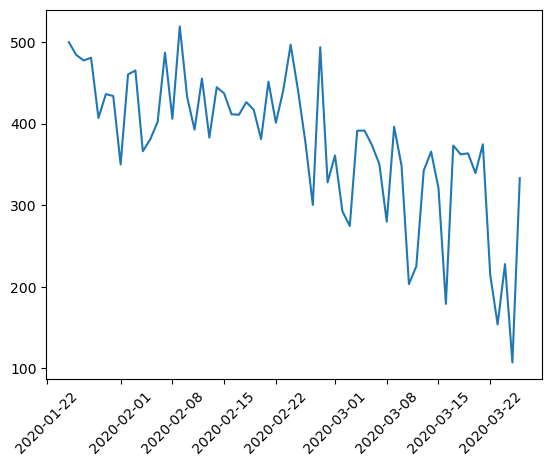

In [27]:
avg_load_day = df.groupby(df['datetime'].dt.date)['net_load'].mean()
plt.plot(avg_load_day)
plt.xticks(rotation=45) 

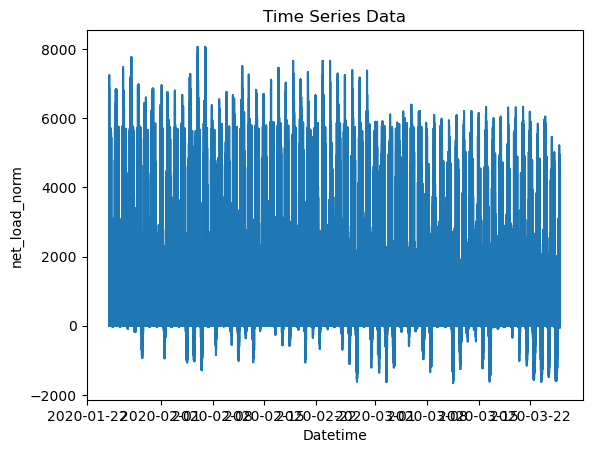

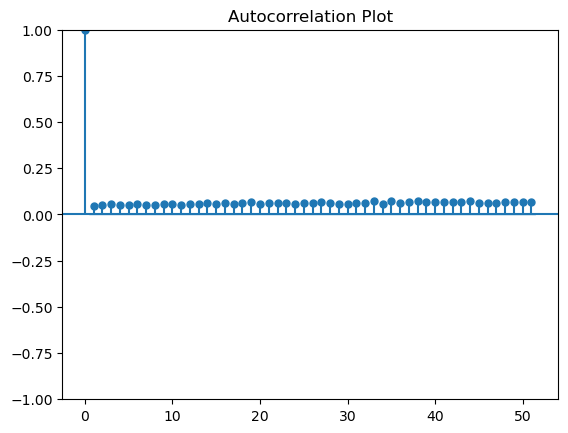

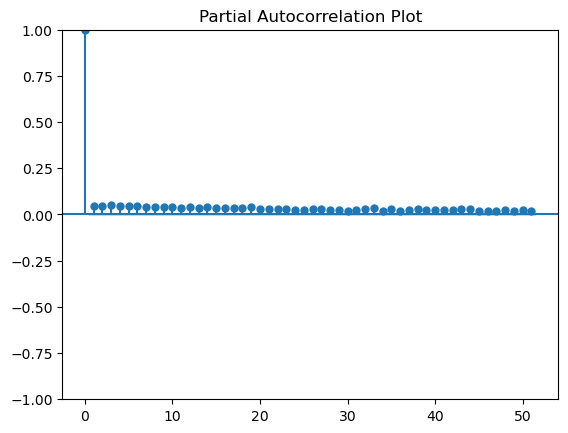

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
df = df.sort_values(by='datetime')

# Plot the time series data
plt.plot(df['datetime'],df['net_load'])
plt.xlabel('Datetime')
plt.ylabel('net_load_norm')
plt.title('Time Series Data')
plt.show()

# Plot autocorrelation and partial autocorrelation plots
plot_acf(df['net_load'])
plt.title('Autocorrelation Plot')
plt.show()

plot_pacf(df['net_load'])
plt.title('Partial Autocorrelation Plot')
plt.show()

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import matplotlib.pyplot as plt
# Run the arim model and get the equation should speed everthing up and also be more complex
'''
df = df.sort_values(by='datetime')
results = pd.DataFrame()
for x in range(4,0,-1):
    vals = x*-24
    train_data = df.iloc[:vals]  
    test_data = df.iloc[vals:]
    test_data = test_data.iloc[:24]

    model = SARIMAX(train_data['net_load_norm'], exog=train_data[['solar_radiation','weekend_or_bank_holiday']], order=(4, 1, 3), seasonal_order=(2, 1, 1, 24))
    sarimax_model = model.fit()

    sarimax_params = sarimax_model.params

    print("SARIMAX Parameters:")
    print(sarimax_params)

    forecast_horizon = 24
    forecast = sarimax_model.forecast(steps=forecast_horizon, exog=test_data[['solar_radiation','weekend_or_bank_holiday']])
    #print('Forecasted Values:', forecast)
    df_final = pd.DataFrame()
    df_final = pd.concat([test_data, forecast], axis=1)
    print(df_final)

    results = pd.concat([results, df_final],ignore_index=True)

results = results.rename(columns={results.columns[-1]: 'forecast'})

plt.figure(figsize=(10, 6))
plt.plot(df['datetime'], df['net_load_norm'], label='Observed')
plt.plot(results['datetime'], results['forecast'], label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMAX Model Forecast')
plt.legend()
plt.xticks(rotation=45) 
plt.grid(alpha=0.3)
plt.show()
'''

'\ndf = df.sort_values(by=\'datetime\')\nresults = pd.DataFrame()\nfor x in range(4,0,-1):\n    vals = x*-24\n    train_data = df.iloc[:vals]  \n    test_data = df.iloc[vals:]\n    test_data = test_data.iloc[:24]\n\n    model = SARIMAX(train_data[\'net_load_norm\'], exog=train_data[[\'solar_radiation\',\'weekend_or_bank_holiday\']], order=(4, 1, 3), seasonal_order=(2, 1, 1, 24))\n    sarimax_model = model.fit()\n\n    sarimax_params = sarimax_model.params\n\n    print("SARIMAX Parameters:")\n    print(sarimax_params)\n\n    forecast_horizon = 24\n    forecast = sarimax_model.forecast(steps=forecast_horizon, exog=test_data[[\'solar_radiation\',\'weekend_or_bank_holiday\']])\n    #print(\'Forecasted Values:\', forecast)\n    df_final = pd.DataFrame()\n    df_final = pd.concat([test_data, forecast], axis=1)\n    print(df_final)\n\n    results = pd.concat([results, df_final],ignore_index=True)\n\nresults = results.rename(columns={results.columns[-1]: \'forecast\'})\n\nplt.figure(figsize=(1

In [30]:
'''
df2 = df[-300:]
plt.figure(figsize=(10, 6))
plt.plot(df2['datetime'], df2['net_load'], label='Observed')
plt.plot(results['datetime'], results['forecast'], label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMAX Model Forecast')
plt.legend()
plt.xticks(rotation=45) 
plt.grid(alpha=0.3)
plt.show()
'''

"\ndf2 = df[-300:]\nplt.figure(figsize=(10, 6))\nplt.plot(df2['datetime'], df2['net_load'], label='Observed')\nplt.plot(results['datetime'], results['forecast'], label='Forecast', color='red')\nplt.xlabel('Date')\nplt.ylabel('Value')\nplt.title('SARIMAX Model Forecast')\nplt.legend()\nplt.xticks(rotation=45) \nplt.grid(alpha=0.3)\nplt.show()\n"

In [31]:
import numpy as np
import pandas as pd
import pmdarima as pm
from tqdm import tqdm
'''
# Run the auto arima get the params then run the non auto with the params for each it

# Assuming 'df' is your dataframe containing the data
train_data = df.iloc[:-336]

# Define ARIMA parameters ( need to trial q = 5)
start_p = 1  
start_d = 1  
start_q = 1  
max_p = 3  
max_d = 2  
max_q = 3  

start_P = 1  
start_D = 1  
start_Q = 2  
max_P = 1  
max_D = 1  
max_Q = 3  


# Initialize tqdm progress bar
with tqdm(total=1) as pbar:
    def progress_callback(iteration):
        pbar.update(1)

    # Train ARIMA model with progress callback
    model_auto = pm.auto_arima(
        train_data['net_load_norm'],
        exogenous=train_data[['solar_radiation','sunshine_duration', 'precipitation_probability']],
        seasonal=True,
        m=48,
        start_p=start_p,
        start_d=start_d,
        start_q=start_q,
        max_d=max_d,
        max_q=max_q,
        start_P=start_P,
        start_D=start_D,
        start_Q=start_Q,
        max_D=max_D,
        max_Q=max_Q,
        stepwise=True,
        method='nm',
        maxiter=50,
        trace=True,
        callback=progress_callback
    )
    '''

"\n# Run the auto arima get the params then run the non auto with the params for each it\n\n# Assuming 'df' is your dataframe containing the data\ntrain_data = df.iloc[:-336]\n\n# Define ARIMA parameters ( need to trial q = 5)\nstart_p = 1  \nstart_d = 1  \nstart_q = 1  \nmax_p = 3  \nmax_d = 2  \nmax_q = 3  \n\nstart_P = 1  \nstart_D = 1  \nstart_Q = 2  \nmax_P = 1  \nmax_D = 1  \nmax_Q = 3  \n\n\n# Initialize tqdm progress bar\nwith tqdm(total=1) as pbar:\n    def progress_callback(iteration):\n        pbar.update(1)\n\n    # Train ARIMA model with progress callback\n    model_auto = pm.auto_arima(\n        train_data['net_load_norm'],\n        exogenous=train_data[['solar_radiation','sunshine_duration', 'precipitation_probability']],\n        seasonal=True,\n        m=48,\n        start_p=start_p,\n        start_d=start_d,\n        start_q=start_q,\n        max_d=max_d,\n        max_q=max_q,\n        start_P=start_P,\n        start_D=start_D,\n        start_Q=start_Q,\n        max_D

In [32]:
def ARIMAorder(data):

    fit = pm.auto_arima(
        data['net_load_norm'],
        exogenous=data[['solar_radiation','sunshine_duration', 'precipitation_probability','weekend_or_bank_holiday']],
        seasonal=True,
        m=48,
        stepwise=True,
        method='nm',
        maxiter=50,
        trace=True,
        start_p=1,
        start_q=1,
        max_p=2,
        max_q=2,
        max_d=2,
        start_P=1,
        start_Q=1,
        max_P=2,
        max_Q=2,
        max_D=2,
    )
    return fit

In [33]:
from sklearn.metrics import mean_absolute_error
'month','day','hour','isweekend','solar radiation', 'sunshine duration','precipitation probability'
'''    start_p=1,
        start_d=1,
        start_q=1,
        max_p=3,
        max_d=2,
        max_q=3,
        start_P=1,
        start_D=1,
        start_Q=1,
        max_P=2,
        max_D=2,
        max_Q=2,
        '''

'    start_p=1,\n        start_d=1,\n        start_q=1,\n        max_p=3,\n        max_d=2,\n        max_q=3,\n        start_P=1,\n        start_D=1,\n        start_Q=1,\n        max_P=2,\n        max_D=2,\n        max_Q=2,\n        '

In [34]:
# THE BIG LOOP
em = ['site','MAE','MSE']
em_df = pd.DataFrame(columns=em)
houses = [2, 3, 6]
#houses = [9, 11, 12, 16] 
#17, 20, 21, 22, 23, 25, 28, 29, 30, 31, 33, 34, 36, 39,41, 42, 46, 49, 50, 53, 57, 61, 62, 64, 73, 77, 81, 84, 85, 90, 91, 94, 98, 100]

# loop for each site
for i in houses:
    site_df = df[df['site']==i]
    site_df['net_load_norm'] = site_df['net_load'] / max(abs(site_df['net_load']))
    site_df_train = site_df[:-1464]
    print('House:',i)
    # run the auto arima and extract the optimal params 
    fit = ARIMAorder(site_df_train)
    results = pd.DataFrame()
    
    # Loop for each day
    for x in range(31,1,-1):
        # get the most up to date data for this predicton
        vals = -x*48 +24 #to get midday
        train_data = site_df.iloc[:vals]  
        test_data = site_df.iloc[vals:]
        test_data = test_data.iloc[:72]

        # Create the model with the new data
        model_auto = SARIMAX(train_data['net_load_norm'], exog=train_data[['solar_radiation','sunshine_duration', 'precipitation_probability','weekend_or_bank_holiday']],order = fit.get_params().get("order"))
        sarimax_model = model_auto.fit()

        # Forecast the next period
        forecast_horizon = 72
        forecast = sarimax_model.forecast(steps=forecast_horizon, exog=test_data[['solar_radiation','sunshine_duration', 'precipitation_probability','weekend_or_bank_holiday']])
        df_final = pd.DataFrame(test_data)
        forecast_df = pd.DataFrame(forecast)
        df_final['forecast'] = forecast_df['predicted_mean'].values
        df_final = df_final[24:]
        results = pd.concat([results, df_final],ignore_index=True)
        print(x-1)

    # add the evaluation metric for the site to a df
    norm_mae = round(mean_absolute_error(results['net_load_norm'], results['forecast']),4)
    norm_mse = round(mean_squared_error(results['net_load_norm'], results['forecast']),4)
    house_res = {'site': i, 'MAE': norm_mae, 'MSE': norm_mse}
    house_res_df = pd.DataFrame([house_res])
    em_df= pd.concat([em_df, house_res_df],ignore_index=True)


    # Plot the figure for each house 
    plt.figure(figsize=(10, 6))
    plt.plot(site_df['datetime'], site_df['net_load_norm'], label='Observed')
    plt.plot(results['datetime'], results['forecast'], label='Forecast', color='red')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('SARIMAX Model Forecast')
    plt.legend()
    plt.xticks(rotation=45) 
    plt.grid(alpha=0.3)
    plt.show()


C:\Users\xlow6\AppData\Local\Temp\ipykernel_2228\1057033742.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_df['net_load_norm'] = site_df['net_load'] / max(abs(site_df['net_load']))


House: 2
Performing stepwise search to minimize aic


 ARIMA(1,1,1)(1,0,1)[48] intercept   : AIC=-3067.411, Time=14.29 sec
 ARIMA(0,1,0)(0,0,0)[48] intercept   : AIC=-2681.115, Time=0.23 sec
 ARIMA(1,1,0)(1,0,0)[48] intercept   : AIC=-2864.125, Time=12.93 sec
 ARIMA(0,1,1)(0,0,1)[48] intercept   : AIC=-3013.001, Time=11.51 sec
 ARIMA(0,1,0)(0,0,0)[48]             : AIC=-2683.114, Time=0.15 sec
 ARIMA(1,1,1)(0,0,1)[48] intercept   : AIC=-3077.022, Time=13.52 sec
 ARIMA(1,1,1)(0,0,0)[48] intercept   : AIC=-3079.672, Time=0.95 sec
 ARIMA(1,1,1)(1,0,0)[48] intercept   : AIC=-3081.121, Time=11.01 sec
 ARIMA(1,1,1)(2,0,0)[48] intercept   : AIC=-3096.188, Time=44.57 sec
 ARIMA(1,1,1)(2,0,1)[48] intercept   : AIC=-3092.199, Time=44.88 sec
 ARIMA(0,1,1)(2,0,0)[48] intercept   : AIC=-3040.759, Time=46.06 sec
 ARIMA(1,1,0)(2,0,0)[48] intercept   : AIC=-2888.737, Time=52.35 sec
 ARIMA(2,1,1)(2,0,0)[48] intercept   : AIC=-3095.221, Time=46.97 sec
 ARIMA(1,1,2)(2,0,0)[48] intercept   : AIC=-3064.203, Time=44.92 sec


MemoryError: Unable to allocate 105. MiB for an array with shape (97, 97, 1465) and data type float64

Exception ignored in: 'statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.reset_filter_method'
Traceback (most recent call last):
  File "statsmodels\tsa\statespace\_kalman_smoother.pyx", line 988, in statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.allocate_arrays
numpy.core._exceptions._ArrayMemoryError: Unable to allocate 105. MiB for an array with shape (97, 97, 1465) and data type float64


AttributeError: Memoryview is not initialized

In [ ]:
print(em_df)

  site     MAE     MSE
0   20  0.1132  0.0243


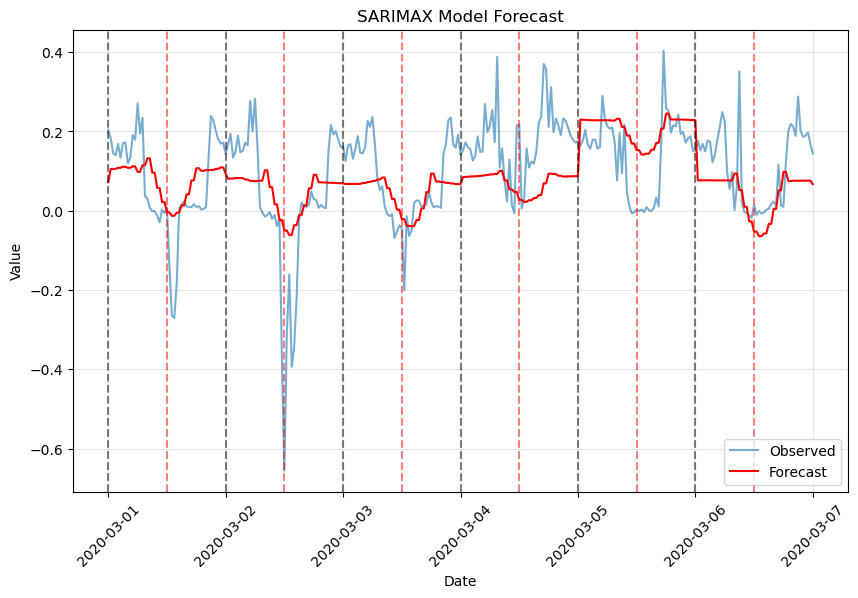

In [ ]:
df2 = site_df[site_df['datetime'] <= '2020-3-7']
df2 = df2[df2['datetime'] >= '2020-3-1']

results2 = results[results['datetime'] <= '2020-3-7']
results2 = results2[results2['datetime'] >= '2020-3-1']

plt.figure(figsize=(10, 6))
plt.plot(df2['datetime'], df2['net_load_norm'], label='Observed',alpha=0.6)
plt.plot(results2['datetime'], results2['forecast'], label='Forecast', color='red',alpha=1)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMAX Model Forecast')
plt.legend()
plt.xticks(rotation=45) 
plt.grid(alpha=0.3)

date_range1 = pd.date_range(start='2020-03-01', end='2020-03-06', freq='D')


# Plot each date with a vertical line at 12:00
for date in date_range1:
    plt.axvline(x=date + pd.Timedelta(hours=12), color='red', linestyle='--', alpha=0.5)
    plt.axvline(x=date, color='black', linestyle='--', alpha=0.5)


In [ ]:
print(site_df_train)

         net_load            datetime  solar_radiation  sunshine_duration  \
33421  258.850006 2020-01-25 00:00:00              0.0                0.0   
33422  245.029999 2020-01-25 00:30:00              0.0                0.0   
33423  237.770004 2020-01-25 01:00:00              0.0                0.0   
33424  305.220001 2020-01-25 01:30:00              0.0                0.0   
33425  217.690002 2020-01-25 02:00:00              0.0                0.0   
...           ...                 ...              ...                ...   
34881  111.680000 2020-02-24 10:00:00             30.0                5.0   
34882  206.960007 2020-02-24 10:30:00             30.0                5.0   
34883   46.950001 2020-02-24 11:00:00             43.0                5.0   
34884  213.080002 2020-02-24 11:30:00             43.0                5.0   
34885  294.470001 2020-02-24 12:00:00             60.0                8.0   

       precipitation_probability  site  weekend_or_bank_holiday  net_load_n

In [ ]:
mse = round(mean_squared_error(results['net_load_norm'], results['forecast']),4)
print(mse)

0.0243


In [ ]:
## 36 Hour forecast
## Train model and save then load model and update each time 
'''
results = pd.DataFrame()
for x in range(30,1,-1):
    vals = -x*48 +24 #to get midday
    train_data = df.iloc[:vals]  
    test_data = df.iloc[vals:]
    test_data = test_data.iloc[:72]

    #model_auto = model_auto.update(train_data['net_load_norm'], exog=train_data[['solar_radiation','sunshine_duration', 'precipitation_probability']], maxiter=1,trace=True,inplace=True)
    #model_auto.update(train_data['net_load_norm'])

    model_auto = SARIMAX(train_data['net_load_norm'], exog=train_data[['solar_radiation','sunshine_duration', 'precipitation_probability']], order=(1, 1, 1), seasonal_order=(1, 0, 0, 48))
    sarimax_model = model_auto.fit()

    #sarimax_params = model_auto.params

    #print("SARIMAX Parameters:")
    #print(sarimax_params)

    forecast_horizon = 72
    forecast = sarimax_model.forecast(steps=forecast_horizon, exog=test_data[['solar_radiation','sunshine_duration', 'precipitation_probability']])
    #forecast, conf_int = model_auto.predict(n_periods=72, exogenous=test_data[['solar_radiation','sunshine_duration', 'precipitation_probability']], return_conf_int=True, order=(1, 1, 1), seasonal_order=(1, 0, 0, 48))
    #forecast = model_auto.predict(n_periods=72, exogenous=test_data[['solar_radiation','sunshine_duration', 'precipitation_probability']], return_conf_int=True, order=(1, 1, 1), seasonal_order=(1, 0, 0, 48))
    df_final = pd.DataFrame(test_data)
    forecast_df = pd.DataFrame(forecast)
    #print(df_final)
    #print(forecast_df)
    df_final['forecast'] = forecast_df['predicted_mean'].values
    df_final = df_final[24:]
    #print(conf_int)

    results = pd.concat([results, df_final],ignore_index=True)
    print(x-1)

#results = results.rename(columns={results.columns[-1]: 'forecast'})

plt.figure(figsize=(10, 6))
plt.plot(df['datetime'], df['net_load_norm'], label='Observed')
plt.plot(results['datetime'], results['forecast'], label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMAX Model Forecast')
plt.legend()
plt.xticks(rotation=45) 
plt.grid(alpha=0.3)
plt.show()
#INdexing and setting params in prediction line
'''

'\nresults = pd.DataFrame()\nfor x in range(30,1,-1):\n    vals = -x*48 +24 #to get midday\n    train_data = df.iloc[:vals]  \n    test_data = df.iloc[vals:]\n    test_data = test_data.iloc[:72]\n\n    #model_auto = model_auto.update(train_data[\'net_load_norm\'], exog=train_data[[\'solar_radiation\',\'sunshine_duration\', \'precipitation_probability\']], maxiter=1,trace=True,inplace=True)\n    #model_auto.update(train_data[\'net_load_norm\'])\n\n    model_auto = SARIMAX(train_data[\'net_load_norm\'], exog=train_data[[\'solar_radiation\',\'sunshine_duration\', \'precipitation_probability\']], order=(1, 1, 1), seasonal_order=(1, 0, 0, 48))\n    sarimax_model = model_auto.fit()\n\n    #sarimax_params = model_auto.params\n\n    #print("SARIMAX Parameters:")\n    #print(sarimax_params)\n\n    forecast_horizon = 72\n    forecast = sarimax_model.forecast(steps=forecast_horizon, exog=test_data[[\'solar_radiation\',\'sunshine_duration\', \'precipitation_probability\']])\n    #forecast, conf_in

In [ ]:
'''
## Day Forecast
results = pd.DataFrame()
for x in range(4,0,-1):
    vals = -x*48
    train_data = df.iloc[:vals]  
    test_data = df.iloc[vals:]
    test_data = test_data.iloc[:48]

    model_auto.update(train_data['net_load_norm'], exog=train_data[['solar_radiation','weekend_or_bank_holiday','sunshine_duration', 'precipitation_probability']], maxiter=1)
    #model_auto.update(train_data['net_load_norm'])

    sarimax_params = model_auto.params

    print("SARIMAX Parameters:")
    print(sarimax_params)

    #forecast_horizon = 24
    #forecast = model.forecast(steps=forecast_horizon, exog=test_data[['solar_radiation','weekend_or_bank_holiday']])
    forecast, conf_int = model_auto.predict(n_periods=48, exogenous=test_data[['solar_radiation','weekend_or_bank_holiday','sunshine_duration', 'precipitation_probability']], return_conf_int=True)
    df_final = pd.DataFrame(test_data)
    df_final['forecast'] = forecast 

    results = pd.concat([results, df_final],ignore_index=True)
    print(x)

results = results.rename(columns={results.columns[-1]: 'forecast'})

plt.figure(figsize=(10, 6))
plt.plot(df['datetime'], df['net_load_norm'], label='Observed')
plt.plot(results['datetime'], results['forecast'], label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMAX Model Forecast')
plt.legend()
plt.xticks(rotation=45) 
plt.grid(alpha=0.3)
plt.show()
'''

'\n## Day Forecast\nresults = pd.DataFrame()\nfor x in range(4,0,-1):\n    vals = -x*48\n    train_data = df.iloc[:vals]  \n    test_data = df.iloc[vals:]\n    test_data = test_data.iloc[:48]\n\n    model_auto.update(train_data[\'net_load_norm\'], exog=train_data[[\'solar_radiation\',\'weekend_or_bank_holiday\',\'sunshine_duration\', \'precipitation_probability\']], maxiter=1)\n    #model_auto.update(train_data[\'net_load_norm\'])\n\n    sarimax_params = model_auto.params\n\n    print("SARIMAX Parameters:")\n    print(sarimax_params)\n\n    #forecast_horizon = 24\n    #forecast = model.forecast(steps=forecast_horizon, exog=test_data[[\'solar_radiation\',\'weekend_or_bank_holiday\']])\n    forecast, conf_int = model_auto.predict(n_periods=48, exogenous=test_data[[\'solar_radiation\',\'weekend_or_bank_holiday\',\'sunshine_duration\', \'precipitation_probability\']], return_conf_int=True)\n    df_final = pd.DataFrame(test_data)\n    df_final[\'forecast\'] = forecast \n\n    results = pd.c

In [ ]:
df2 = df[-1440:]
plt.figure(figsize=(10, 6))
plt.plot(df2['datetime'], df2['net_load_norm'], label='Observed',alpha=0.6)
plt.plot(results['datetime'], results['forecast'], label='Forecast', color='red',alpha=1)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMAX Model Forecast')
plt.legend()
plt.xticks(rotation=45) 
plt.grid(alpha=0.3)

#plt.axvline(x=pd.to_datetime('2020-3-24 12:00:00'), color='black', linestyle='--',linewidth=1)

start_date = pd.Timestamp('2020-02-26')  # Replace with your desired start date
end_date = pd.Timestamp('2020-03-26')    # Replace with your desired end date
plt.xlim(start_date, end_date)
plt.ylim(-1,1)



plt.show()

KeyError: 'net_load_norm'

<Figure size 1000x600 with 0 Axes>

In [ ]:
from sklearn.metrics import mean_absolute_error
norm_mae = mean_absolute_error(results['net_load_norm'], results['forecast'])
print(round(norm_mae,4))

def mean_absolute_arctangent_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(np.arctan((y_true - y_pred) / np.abs(y_true)) / (np.pi / 2)))

maape = mean_absolute_arctangent_percentage_error(results['net_load_norm'], results['forecast'])
print(round(maape,3))


0.173
0.523
